# Migration to Los Angeles County

### Import python tools

In [1]:
import pandas as pd
import jenkspy 
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
import os
import seaborn as sns
import altair_latimes as lat
import altair as alt
from pandas.io.json import json_normalize 
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

### Read data downloaded from IRS

In [2]:
# source_files = sorted(Path('/Users/mhustiles/data/github/notebooks/migration/input/irs/').glob('*.csv'))

# dataframes = []
# for f in source_files:
#     df = pd.read_csv(f, encoding = "ISO-8859-1")
#     df['source'] = f.name
#     df['source'] = df['source'].str.replace('countyoutflow', '').str.replace('.csv', '', regex=False)
#     dataframes.append(df)

# src = pd.concat(dataframes, sort=False)

In [3]:
df_1011 = pd.read_csv('input/irs/countyoutflow1011.csv', sep=',', encoding='latin-1')
df_1112 = pd.read_csv('input/irs/countyoutflow1112.csv', sep=',', encoding='latin-1')
df_1213 = pd.read_csv('input/irs/countyoutflow1213.csv', sep=',', encoding='latin-1')
df_1314 = pd.read_csv('input/irs/countyoutflow1314.csv', sep=',', encoding='latin-1')
df_1415 = pd.read_csv('input/irs/countyoutflow1415.csv', sep=',', encoding='latin-1')
df_1516 = pd.read_csv('input/irs/countyoutflow1516.csv', sep=',', encoding='latin-1')

In [4]:
src = pd.concat([df_1011,df_1112,df_1213,df_1314,df_1415,df_1516], sort=False)

### Process data types and fields

In [5]:
all_years = src.astype({'y1_statefips': 'str',\
                        'y1_countyfips': 'str',\
                        'y2_statefips': 'str',\
                        'y2_countyfips': 'str'}, inplace=True)

In [6]:
all_years['y1_statefips'] = all_years['y1_statefips'].str.zfill(2)
all_years['y1_countyfips'] = all_years['y1_countyfips'].str.zfill(3)
all_years['y2_statefips'] = all_years['y2_statefips'].str.zfill(2)
all_years['y2_countyfips'] = all_years['y2_countyfips'].str.zfill(3)

In [7]:
all_years['y1_fips'] = all_years['y1_statefips'] + all_years['y1_countyfips']
all_years['y2_fips'] = all_years['y2_statefips'] + all_years['y2_countyfips']
all_years['geoid'] = all_years['y2_fips']

In [8]:
all_years.head()

,y1_statefips,y1_countyfips,y2_statefips,y2_countyfips,y2_state,y2_countyname,n1,n2,agi,y1_fips,y2_fips,geoid
0,00,000,96,000,US,Total Mig - US & For,6991456,12967005,304464050,00000,96000,96000
1,00,000,97,000,US,Total Mig - US,6890106,12775807,299138260,00000,97000,97000
2,00,000,97,001,US,Total Mig - US Same St,3916380,7260905,157646960,00000,97001,97001
3,00,000,97,003,US,Total Mig - US Diff St,2973726,5514902,141491300,00000,97003,97003
4,00,000,98,000,US,Total Mig - Foreign,101350,191198,5325790,00000,98000,98000


### Filter national aggregates and LAC tax filers who stayed in LAC

In [9]:
aggregates = ['57', '58', '59', '96', '97', '98']

In [10]:
la_out = all_years[\
#                       (all_years['y2_state'] != 'NY') &\
#                       (all_years['y2_state'] != 'NJ') &\
                      (all_years['y1_fips'] == '06037') &\
                      (all_years['y2_fips'] != '06037') &\
                      (~all_years.y2_statefips.isin(aggregates))]

In [11]:
aggregated = all_years[all_years.y2_statefips.isin(aggregates)]

In [12]:
total = pd.DataFrame(aggregated[(aggregated['y2_countyname'].str.contains('Total Migration-Different State')) &\
                   (aggregated['y2_statefips'] != '96') &\
                  (aggregated['y1_countyfips'] != '000')])

In [13]:
total['merge_fips_norm'] = total['y1_statefips'] + total['y1_countyfips']

In [14]:
normalization_totals = total.groupby(['merge_fips_norm']).agg({'n1':'sum'}).reset_index()

### Group by locations where tax filers moved

In [15]:
migration = la_out.groupby(['y2_fips', 'y2_state', 'y2_countyname', 'geoid']).agg({'n1':'sum'}).reset_index()

In [16]:
migration.rename(columns={'n1':'tax_migrants_from_lac'}, 
                 inplace=True)

In [17]:
migration.head(100)

,y2_fips,y2_state,y2_countyname,geoid,tax_migrants_from_lac
0,01003,AL,Baldwin County,01003,48
1,01069,AL,Houston County,01069,10
2,01073,AL,Jefferson County,01073,355
3,01081,AL,Lee County,01081,54
4,01089,AL,Madison County,01089,251
5,01097,AL,Mobile County,01097,182
6,01101,AL,Montgomery County,01101,137
7,01117,AL,Shelby County,01117,74
8,01125,AL,Tuscaloosa County,01125,51
9,02020,AK,Anchorage Municipality,02020,687


### How many tax filers who left LAC in total?

In [18]:
migration.tax_migrants_from_lac.sum()

740469

### How many tax filers who left LAC moved to each state?

In [19]:
states = migration.groupby(['y2_state']).agg({'tax_migrants_from_lac':'sum'}).reset_index()
states.sort_values(by='tax_migrants_from_lac',ascending=False).head(10)

,y2_state,tax_migrants_from_lac
4,CA,441223
43,TX,39044
33,NV,31418
34,NY,24870
3,AZ,23460
9,FL,19302
47,WA,19064
37,OR,12137
5,CO,11682
14,IL,9899


In [20]:
migration.sort_values(by='tax_migrants_from_lac',ascending=False).head(10)

,y2_fips,y2_state,y2_countyname,geoid,tax_migrants_from_lac
64,06059,CA,Orange County,06059,113312
70,06071,CA,San Bernardino County,06071,97877
67,06065,CA,Riverside County,06065,56228
71,06073,CA,San Diego County,06073,33206
88,06111,CA,Ventura County,06111,31826
397,32003,NV,Clark County,32003,28418
19,04013,AZ,Maricopa County,04013,15315
51,06029,CA,Kern County,06029,15296
77,06085,CA,Santa Clara County,06085,11430
72,06075,CA,San Francisco County,06075,11429


In [21]:
normal_migration = pd.merge(migration, normalization_totals, left_on='geoid', right_on='merge_fips_norm', how='inner')

In [22]:
normal_migration.head()

,y2_fips,y2_state,y2_countyname,geoid,tax_migrants_from_lac,merge_fips_norm,n1
0,01003,AL,Baldwin County,01003,48,01003,12878
1,01069,AL,Houston County,01069,10,01069,6500
2,01073,AL,Jefferson County,01073,355,01073,29730
3,01081,AL,Lee County,01081,54,01081,12151
4,01089,AL,Madison County,01089,251,01089,22043


In [23]:
normal_migration.rename(columns={'n1':'all_tax_migrants_to_county'}, 
                 inplace=True)

In [24]:
normal_migration.head()

,y2_fips,y2_state,y2_countyname,geoid,tax_migrants_from_lac,merge_fips_norm,all_tax_migrants_to_county
0,01003,AL,Baldwin County,01003,48,01003,12878
1,01069,AL,Houston County,01069,10,01069,6500
2,01073,AL,Jefferson County,01073,355,01073,29730
3,01081,AL,Lee County,01081,54,01081,12151
4,01089,AL,Madison County,01089,251,01089,22043


In [25]:
normal_migration['rate_per_1000'] = \
    (normal_migration['tax_migrants_from_lac'] / normal_migration['all_tax_migrants_to_county'])*1000

In [26]:
normal_migration['pct_all_migrants_from_lac'] = \
    (normal_migration['tax_migrants_from_lac'] / 740469)*100

In [27]:
normal_migration.sort_values(by='rate_per_1000', ascending=False).head(10)

,y2_fips,y2_state,y2_countyname,geoid,tax_migrants_from_lac,merge_fips_norm,all_tax_migrants_to_county,rate_per_1000,pct_all_migrants_from_lac
70,06071,CA,San Bernardino County,06071,97877,06071,69307,1412.223873,13.218244
64,06059,CA,Orange County,06059,113312,06059,100826,1123.837106,15.302734
88,06111,CA,Ventura County,06111,31826,06111,28998,1097.523967,4.298087
67,06065,CA,Riverside County,06065,56228,06065,69901,804.394787,7.593566
51,06029,CA,Kern County,06029,15296,06029,23309,656.227208,2.065718
74,06079,CA,San Luis Obispo County,06079,3416,06079,9446,361.634554,0.461329
76,06083,CA,Santa Barbara County,06083,5749,06083,16023,358.796730,0.776400
60,06051,CA,Mono County,06051,362,06051,1104,327.898551,0.048888
86,06107,CA,Tulare County,06107,2438,06107,8029,303.649271,0.329251
50,06027,CA,Inyo County,06027,324,06027,1092,296.703297,0.043756


In [28]:
normal_migration.sort_values(by='pct_all_migrants_from_lac', ascending=False).head(10)

,y2_fips,y2_state,y2_countyname,geoid,tax_migrants_from_lac,merge_fips_norm,all_tax_migrants_to_county,rate_per_1000,pct_all_migrants_from_lac
64,06059,CA,Orange County,06059,113312,06059,100826,1123.837106,15.302734
70,06071,CA,San Bernardino County,06071,97877,06071,69307,1412.223873,13.218244
67,06065,CA,Riverside County,06065,56228,06065,69901,804.394787,7.593566
71,06073,CA,San Diego County,06073,33206,06073,182339,182.111342,4.484455
88,06111,CA,Ventura County,06111,31826,06111,28998,1097.523967,4.298087
397,32003,NV,Clark County,32003,28418,32003,173019,164.247857,3.837838
19,04013,AZ,Maricopa County,04013,15315,04013,238690,64.162722,2.068284
51,06029,CA,Kern County,06029,15296,06029,23309,656.227208,2.065718
77,06085,CA,Santa Clara County,06085,11430,06085,58452,195.545063,1.543616
72,06075,CA,San Francisco County,06075,11429,06075,44499,256.837232,1.543481


### Prepare natural breaks for mapping

In [29]:
breaks = jenkspy.jenks_breaks(list(normal_migration.rate_per_1000), nb_class=7)

In [30]:
breaks

[0.8385744234800838,
 30.55022392834293,
 98.06527839314724,
 212.02297673889552,
 361.6345543087021,
 804.3947869129197,
 1123.8371055084997,
 1412.2238734904122]

In [31]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

### Attach break groups to dataframe

In [32]:
normal_migration['mover_group'] = normal_migration.rate_per_1000.apply(get_group)

In [33]:
normal_migration.sort_values(by='rate_per_1000',ascending=False).head(20)

,y2_fips,y2_state,y2_countyname,geoid,tax_migrants_from_lac,merge_fips_norm,all_tax_migrants_to_county,rate_per_1000,pct_all_migrants_from_lac,mover_group
70,06071,CA,San Bernardino County,06071,97877,06071,69307,1412.223873,13.218244,6
64,06059,CA,Orange County,06059,113312,06059,100826,1123.837106,15.302734,5
88,06111,CA,Ventura County,06111,31826,06111,28998,1097.523967,4.298087,5
67,06065,CA,Riverside County,06065,56228,06065,69901,804.394787,7.593566,4
51,06029,CA,Kern County,06029,15296,06029,23309,656.227208,2.065718,4
74,06079,CA,San Luis Obispo County,06079,3416,06079,9446,361.634554,0.461329,3
76,06083,CA,Santa Barbara County,06083,5749,06083,16023,358.796730,0.776400,3
60,06051,CA,Mono County,06051,362,06051,1104,327.898551,0.048888,3
86,06107,CA,Tulare County,06107,2438,06107,8029,303.649271,0.329251,3
50,06027,CA,Inyo County,06027,324,06027,1092,296.703297,0.043756,3


---

### Import U.S. counties geography

In [34]:
counties = gpd.read_file('/Users/mhustiles/data/data/GIS/usa/counties_lakes.shp')

In [35]:
counties.columns = counties.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Remove Alaska and Hawaii

In [36]:
lower48 = counties[(counties['statefp'] != '15') & (counties['statefp'] != '02')]

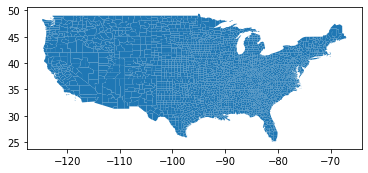

In [37]:
lower48.plot()

In [38]:
lower48.head()

,objectid,statefp,countyfp,countyns,geoid,name,namelsad,lsad,classfp,mtfcc,...,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,shape_leng,shape_area,geometry
1,2,41,003,01155126,41003,Benton,Benton County,06,H1,G4020,...,18700,None,A,1.748713e+09,7.740249e+06,+44.4938816,-123.4246641,2.639293,0.198723,"POLYGON ((-123.1490250002036 44.7202249998839,..."
2,3,41,011,01135848,41011,Coos,Coos County,06,H1,G4020,...,18300,None,A,4.133690e+09,5.447528e+08,+43.1859095,-124.0941335,3.350173,0.471548,POLYGON ((-123.8115530001708 42.78883700052722...
3,4,06,045,00277287,06045,Mendocino,Mendocino County,06,H1,G4020,...,46380,None,A,9.081427e+09,9.629462e+08,+39.4323876,-123.4428811,5.271028,0.935848,POLYGON ((-123.5444580001366 40.00192299984661...
4,5,41,041,01135856,41041,Lincoln,Lincoln County,06,H1,G4020,...,35440,None,A,2.539210e+09,5.546691e+08,+44.6410607,-123.9112121,2.577066,0.294925,POLYGON ((-123.7246629996977 45.04443200043653...
5,6,06,023,01681908,06023,Humboldt,Humboldt County,06,H1,G4020,...,21700,None,A,9.241252e+09,1.254039e+09,+40.7066554,-123.9261757,4.846712,0.977044,POLYGON ((-123.6613629998026 41.38208999975376...


---

### Merge geography with migration data

In [39]:
migration_map = pd.merge(lower48, normal_migration, on='geoid')

In [40]:
migration_map.loc[0]

objectid                                                                      2
statefp                                                                      41
countyfp                                                                    003
countyns                                                               01155126
geoid                                                                     41003
name                                                                     Benton
namelsad                                                          Benton County
lsad                                                                         06
classfp                                                                      H1
mtfcc                                                                     G4020
csafp                                                                       440
cbsafp                                                                    18700
metdivfp                                

In [41]:
slim = migration_map[['geoid','name','mover_group','rate_per_1000','geometry']]

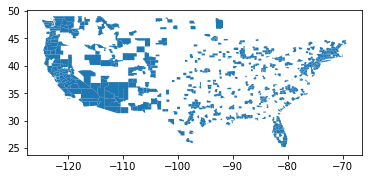

In [42]:
slim.plot()

In [ ]:
geojson = json.loads(slim.to_json())
features = alt.Data(values=geojson['features'])

In [ ]:
background = alt.Chart(features).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('albersUsa')

In [ ]:
base = alt.Chart(features).mark_geoshape(
    fill='lightgray',
    strokeWidth=0.1,
    stroke='white'
).properties(
    width=800,
    height=500
).project('albersUsa')

In [ ]:
geoshape = alt.Chart(features).mark_geoshape(
    fill='lightgray',
    stroke='white'
)

In [ ]:
movers = geoshape.encode(
    color=alt.Color(
        "properties.mover_group:N",
        scale=alt.Scale(
            domain=[0,1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
)

In [ ]:
(base + movers).properties(title="LA County out migration: 2010-2015").configure_view(
    strokeWidth=0 
)